In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mag_data = pd.read_csv("max_mag_by_month.csv")
mag_data.head()

,time,A,B,C,D,E,F,G
0,1960-01-01,0.0,0.0,0.0,6.3,0.0,0.0,0.0
1,1960-02-01,0.0,0.0,0.0,0.0,0.0,6.1,0.0
2,1960-03-01,0.0,0.0,0.0,0.0,0.0,8.0,0.0
3,1960-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1960-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
mag_data.index = pd.to_datetime(mag_data.time)

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

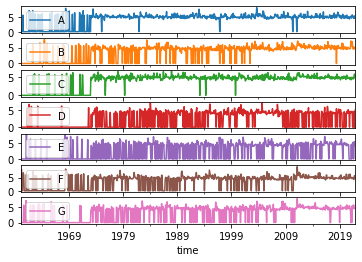

In [5]:
mag_data.plot(subplots=True)

In [8]:
mag_data.drop(["time"], inplace=True, axis=1)

In [6]:
len(mag_data)

744

In [9]:
# We will split the data in training and testing set
TRAIN_SPLIT = 600 
dataset = mag_data.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset - data_mean) / data_std

In [10]:
def multivariate_split(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data, labels = [], []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

For comparison purposes, we will use a 10 year lookback window with a 1 year prediction and a 25 year lookback window with a 5 year prediction.

In [12]:
past_history = 120
future_target = 12
STEP = 1

X_train_multi, y_train_multi = multivariate_split(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP)

X_val_multi, y_val_multi = multivariate_split(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP)

In [13]:
print(X_train_multi.shape, y_train_multi.shape)

(480, 120, 7) (480, 12)


In [ ]:
BATCH_SIZE = 30
BUFFER_SIZE = 100

In [18]:
train_data_multi = tf.data.Dataset.from_tensor_slices((X_train_multi, y_train_multi))
#train_data_multi = train_data_multi.cache().batch()

val_data_multi = tf.data.Dataset.from_tensor_slices((X_val_multi, y_val_multi))

In [17]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=X_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(128, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))


multi_step_model.compile(optimizer='Adam', loss='mse')
print(multi_step_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 120, 128)          69632     
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                                 
Total params: 202,764
Trainable params: 202,764
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10, validation_data=val_data_multi, callbacks=[early_stopping])

Epoch 1/10


ValueError: in user code:

    File "C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 120, 7), found shape=(120, 7)
